In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Built-in modules
import os
import json
import datetime as dt
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Visualisation utilities from utils.py
from utils import get_extent, md5_encode_files

In [3]:
import sys
sys.path.append('./ai4eo/')

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

In [5]:
path = "/work/ka1176/shared_data/2021-ai4eo/eopatches/train/"
print(len(os.listdir(path)))

100


In [6]:
testpath = "/work/ka1176/shared_data/2021-ai4eo/eopatches/test/"
print(len(os.listdir(testpath)))

25


## Valid data

TODO: Process the training data to find the valid data (both IS_DATA and CLM cloud mask)

## Subsample

Demonstrate the usage for one eopatch

In [7]:
from ai4eo.eotasks import SamplePatchletsTask

In [8]:
eopatch = EOPatch.load(os.path.join(path, 'eopatch-823'))

In [9]:
systematic_sample_task = SamplePatchletsTask(s2_patchlet_size=32, num_samples=15*15, random_mode=False)
random_sample_task = SamplePatchletsTask(s2_patchlet_size=32, num_samples=15*15, random_mode=True)

In [10]:
systematic_samples = systematic_sample_task.execute(eopatch)
random_samples = random_sample_task.execute(eopatch)

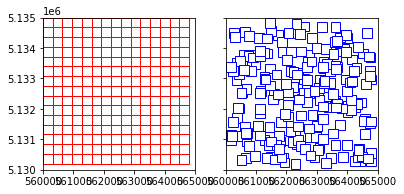

In [11]:
tidx = 0

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

for sample in systematic_samples:
    extent = get_extent(sample)
    
    rect = plt.Rectangle((extent[0], extent[2]), extent[1]-extent[0], extent[3]-extent[2], ls='-', edgecolor='r', facecolor='w')
    ax[0].add_patch(rect)
    
for sample in random_samples:
    extent = get_extent(sample)
    
    rect = plt.Rectangle((extent[0], extent[2]), extent[1]-extent[0], extent[3]-extent[2], ls='-', edgecolor='b', facecolor='w')
    ax[1].add_patch(rect)
    
extent = get_extent(eopatch)
ax[0].set_xlim(extent[0], extent[1])
ax[0].set_ylim(extent[2], extent[3])
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
    
plt.show()

Look at one sample in detail. It contains the same features as the EOPatch, just the spatial dimension is cut down as specified

In [12]:
sample

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 32, 32, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 32, 32, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(128, 128, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 32
    size_y: 32
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((561600.0, 5130530.0), (56

The sample, shown in the RGB channels at 10 m resolution for different time indices (the other 9 channels are not shown here)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


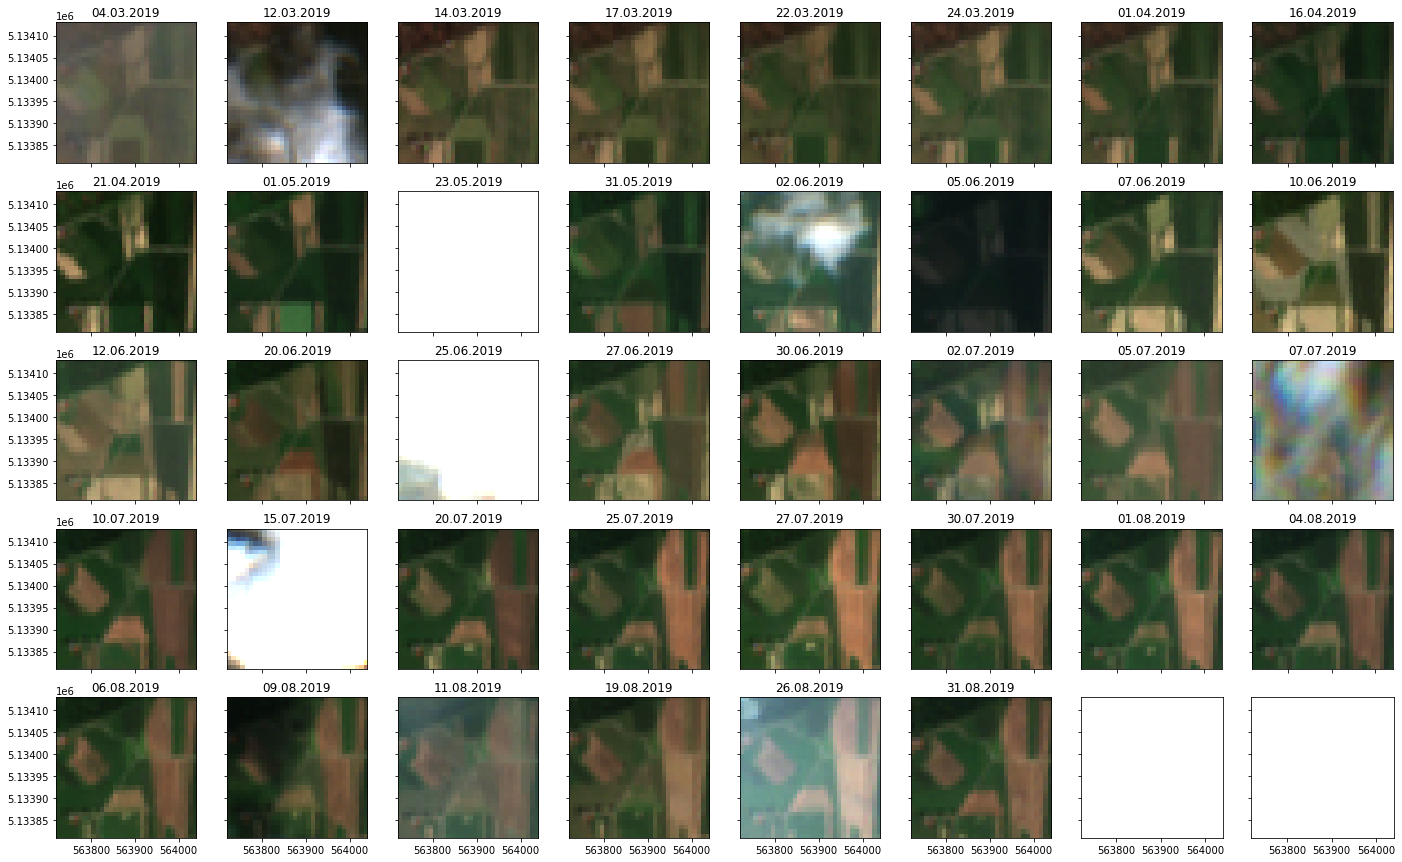

In [13]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=[3*8, 3*5])
axs = axs.flatten()
sample = random_samples[7] # pick one sample at random

for tidx,ax in zip(range(38), axs):
    norm_factor = sample.scalar['NORM_FACTORS'][tidx]
    ax.imshow(3.5 * norm_factor * sample.data['BANDS'][tidx][..., [3,2,1]], extent=get_extent(sample))
    ax.set_title(sample.timestamp[tidx].strftime('%d.%m.%Y'))
#axs[-2].imshow(sample.data[])
#axs[-1].imshow(sample.mask_timeless['CULTIVATED'].squeeze())

The annotated map

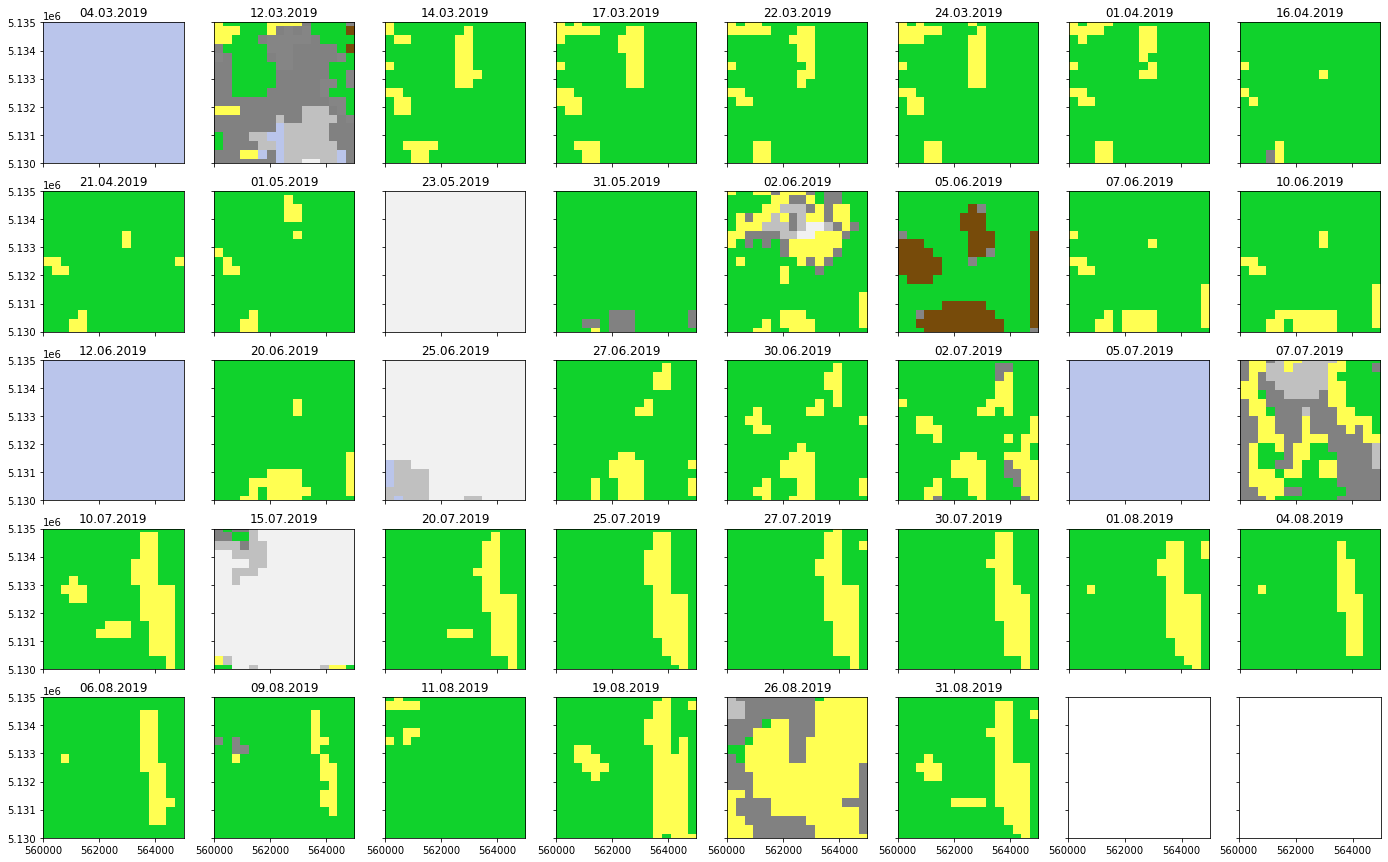

In [14]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=[3*8, 3*5])
axs = axs.flatten()
sample = random_samples[7] # pick one sample at random

for tidx,ax in zip(range(38), axs):
    norm_factor = sample.scalar['NORM_FACTORS'][tidx]
    ax.imshow(sample.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(eopatch), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11)
    ax.set_title(sample.timestamp[tidx].strftime('%d.%m.%Y'))


The target map. Note the target map dimension is 4 * the sample dimension

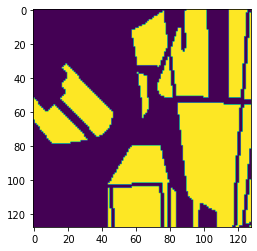

In [15]:
plt.imshow(sample.mask_timeless['CULTIVATED'].squeeze())

## Generate training and validation samples

Proposal:
- Start with using all 12 channels and the 1 annotated SCL map
- Start with excluding all maps that contain any clouds
- Subselect maps of 32 * 32 from the 500 * 500 EOPatches --> Up to 15 * 15 * 100 = 22,500 patches for training and validation
- Find a suitable subset of time stamps per EOPatch, restricted by missing data / clouds. If there are more available, randomly subselect

Save the samples as numeric data, keeping the temporal information in case we would want to use it explicitly later on

This EO workflow demonstration for machine learning seems very useful:

https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html?highlight=distribute

In [22]:
from eolearn.mask.masking import AddValidDataMaskTask # pass a function that returns a truth value
from eolearn.core import LinearWorkflow

In [17]:
def is_valid_data(eopatch):
    '''returns pixel wise condition:
    IS_DATA & ~CLM (cloud mask)'''
    return eopatch.mask['IS_DATA'] & ~eopatch.mask['CLM']

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
validtask = AddValidDataMaskTask(is_valid_data)

# OUTLINE

# Preprocessing part

# more tasks include:
# add valid count (that can be thresholded)#
# erosion (remove random 1 pixel features)
# time interpolation to the same time stamp ...?
# random time stamp subselection
# random cropping
# assign to train or validation set
# band normalization
# ...
# finally, save to disk --> set of subsampled eopatches

# we now have a set of eopatches that are saved to disk (train / validation folders separately) --> avoids hdf5, which would require installing a separate package possibly in conflict with the submission rules
# we should have some parameters that control the generation of such a data set

# ML part
# Load all the sample patches (they fit in memory, no problem here)
# PyTorch dataset
# PyTorch model
# MCC metric
# Per the reproducibility rules, we should not use pytorch lightning

# Submission part
# Need to generate TIF in the end

In [ ]:
# linear workflow defined as a graph
# send it to the EOExecutor that can conveniently parallelize the execution (per EOPatch?)

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


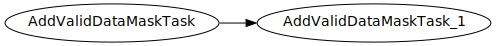

In [27]:
workflow = LinearWorkflow(validtask, validtask) # we could add more here
workflow.dependency_graph()
#filtered_patch = workflow.execute([eopatch])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


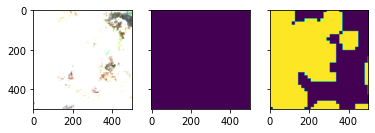

In [20]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(filtered_patch.data['BANDS'][1][..., [3,2,1]])
ax[1].imshow(filtered_patch.mask['IS_DATA'][1].squeeze())
ax[2].imshow(filtered_patch.mask['CLM'][1].squeeze())